## Setup and Config

In [5]:
import numpy as np
import pandas as pd
import os, glob, re, sys
import datetime
from datetime import date, timedelta


In [6]:
###Setup working directory

workfolder = r"C:\Users\benqi\Documents\Human Capital Analytics\CHS Attrition"
RDPfolder = r"C:\Users\benqi\Documents\Qlik\RDP"

def main(workfolder):
    
    print("Current Working Directory " , os.getcwd())
    
    
    try:
        # Change the current working Directory    
        os.chdir(workfolder)
        print("Directory changed")
    except OSError:
        print("Can't change the Current Working Directory")        
    print("Current Working Directory " , os.getcwd())
    
    # Check if New path exists
    if os.path.exists(workfolder) :
        # Change the current working Directory    
        os.chdir(workfolder)
    else:
        print("Can't change the Current Working Directory")    
        
    
    print("Current Working Directory " , os.getcwd())
    
if __name__ == '__main__':
    main(workfolder)

Current Working Directory  C:\Users\benqi\Documents\Human Capital Analytics\CHS Attrition
Directory changed
Current Working Directory  C:\Users\benqi\Documents\Human Capital Analytics\CHS Attrition
Current Working Directory  C:\Users\benqi\Documents\Human Capital Analytics\CHS Attrition


## Getting MIP Data 

In [73]:
###Load CHS Employee files 

CHSfile= workfolder + '\CHS_*' + '.xlsx'

try: 
    df_CHS=pd.concat([pd.read_excel(x,na_values=[''])for x in glob.glob(CHSfile)])
except Exception as ex: 
    print(ex) 


df_CHS.sort_values(['As-of Month','Emplid'],inplace=True)

In [74]:
###Clean Data files

df_raw=df_CHS.drop_duplicates(subset=['Emplid'],keep='last')
df_raw=df_raw.dropna(subset=['Citizenship Category'])
df_raw=df_raw[df_raw['Citizenship Category'].str.contains('Singap')]
df_raw.rename(columns={'As-of Month':'Last CHS Month'},inplace = True)

###Check duplicate employees 

no_dupe = len(df_raw[df_raw.duplicated(subset=['Name (Current)','Date of Birth'],keep=False)].sort_values('Name Known'))

print('{} dupe are found'.format(no_dupe))
###df_raw.to_csv('chs.csv')

0 dupe are found


## Getting ID Mapping Data , Working Hours Data and Perf Grade Data

In [75]:
###Create ID Mapping Dict

IDfile= workfolder + '\IDMap*' + '.xlsx'

try: 
    df_IDMap=pd.concat([pd.read_excel(x,na_values=[''])for x in glob.glob(IDfile)])
except Exception as ex: 
    print(ex) 


df_id=df_IDMap[['Emplid','Previous Employee Id']]
df_IDMap=df_id[df_id['Previous Employee Id'].str.len()>1][['Emplid','Previous Employee Id']].drop_duplicates()
dict_IDMap = dict(zip(list(df_IDMap['Previous Employee Id']),list(df_IDMap['Emplid'])))

In [76]:
###Load working hour files 

workinghourfile= RDPfolder + '\WH_*' + '.xlsx'

try: 
    df_hour=pd.concat([pd.read_excel(x,na_values=[''])for x in glob.glob(workinghourfile)])
except Exception as ex: 
    print(ex) 
 
    
    

In [77]:
###Load perf grade file

perfgradefile = workfolder + '\Perf*' + 'xlsx'

try: 
    df_PG=pd.concat([pd.read_excel(x,na_values=[''])for x in glob.glob(perfgradefile)])
except Exception as ex: 
    print(ex) 
    
df_PGMap = df_PG[['Empl ID','PG']]

In [78]:
###Clean working hour file

df_hour['Roster Type new']=pd.to_numeric(df_hour['Roster Type'],errors='coerce')
df_hour['working hours']=df_hour['Manshifts (Worked)']* (df_hour['Roster Type new']-1)+df_hour['Total OT Hrs (Incl Rest Day)']
df_hour_raw = df_hour[['Name','Citizenship','Job Cat','Month','working hours']]
df_hour_raw['ID'] = df_hour['ID'].apply(lambda x: dict_IDMap[x] if x in dict_IDMap.keys() else x)
df_hour_raw.head()

df_hour_grp=df_hour_raw.groupby('ID')['working hours'].mean().to_frame(name = 'working hours').reset_index()



<ipython-input-78-6984e693027f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hour_raw['ID'] = df_hour['ID'].apply(lambda x: dict_IDMap[x] if x in dict_IDMap.keys() else x)


In [79]:
###Join working hour to Data file

df_raw=df_raw.merge(df_hour_grp,left_on='Emplid',right_on='ID',how='left')

In [80]:
###ETL 

df_raw.drop(df_raw.columns.difference(['Last CHS Month','Active/Left','Emplid','Attrition Reason', 'Citizenship Category', 'Date Left',
       'Date of Birth','Hire Date','Marital Status','Name Known' ,'Job Code','working hours']),axis=1,inplace=True)


df_raw['Last CHS Month'] = df_raw['Last CHS Month'].dt.date
df_raw['Hire Date'] = pd.to_datetime(df_raw['Hire Date']).dt.date

df_raw['Date of Birth']=pd.to_datetime(df_raw['Date of Birth']).dt.date
df_raw['Date Left'] = pd.to_datetime(df_raw['Date Left'],errors='coerce').dt.date

df_raw['Age at hire']=(df_raw['Hire Date']-df_raw['Date of Birth'])// timedelta(days=365.2425)


## Generate Yearly File

In [184]:
###Loop thru file to generate yearly data

year = [2017,2018,2019]

df_temp = []
for i in year:
    
    print(i)
    yearend = datetime.date(i,12,31)
    nyearstart = datetime.date(i+1,1,1)
    nyearend = datetime.date(i+1,12,31)

    df_year = df_raw[(df_raw['Last CHS Month']>yearend) & (df_raw['Hire Date']<nyearstart)]
    

    ### Add Svc years
    df_year['Svc Year']=(yearend-df_year['Hire Date'])// timedelta(days=365.2425)

    ### Add Age at year end
    df_year['Age at year']=(yearend-df_year['Date of Birth'])// timedelta(days=365.2425)

    ### Add voluntary indicator

    voluntary = (df_year['Active/Left']=='Left') & (df_year['Attrition Reason'].str.contains('Resignation|Vacation')) & (df_year['Date Left']<nyearend)
    df_year.loc[voluntary,'Voluntary']=1
    df_year.loc[:,'Voluntary'].fillna(0,inplace=True)
 
    df_temp.append(df_year)



df_year= pd.concat(df_temp, ignore_index=True)

2017
2018
2019


<ipython-input-184-5590ed345172>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['Svc Year']=(yearend-df_year['Hire Date'])// timedelta(days=365.2425)
<ipython-input-184-5590ed345172>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['Age at year']=(yearend-df_year['Date of Birth'])// timedelta(days=365.2425)
C:\Users\benqi\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [185]:
###Add PG data
df_year=df_year.merge(df_PGMap,left_on='Emplid',right_on='Empl ID',how='left')


#df_year.to_excel('CHS2018.xlsx')

In [212]:
###Clean up data
df_year.drop(df_year.columns.difference(['Marital Status','Job Code','working hours','Age at hire','Svc Year','Age at year','Voluntary','PG']),axis=1,inplace=True)

df_year.to_excel('CHSyear.xlsx')

## Preparing the data for Model Generation
df_year['PG'] = df_year['PG'].map({'E':0,'D':1,'C':2,'C+':3,'B':4,'B+':5,'A':6})

## EDA

0.0    1623
1.0     160
Name: Voluntary, dtype: int64


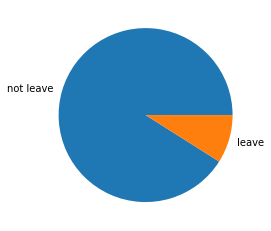

In [213]:
# Import seaborn and matplotlib with matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Getting the count of people that leave and not
leftcounts=df_year['Voluntary'].value_counts()
print(leftcounts)

# Using matplotlib pie chart and label the pie chart
plt.pie(leftcounts,labels=['not leave','leave']);

<AxesSubplot:xlabel='PG', ylabel='count'>

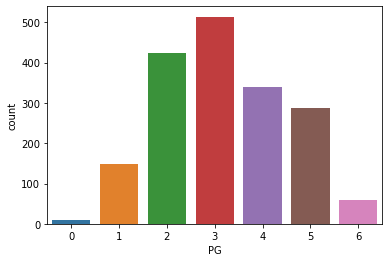

In [214]:
###Compute missing value if any

plotorder = df_year['PG'].value_counts().sort_index().index
sns.countplot(x='PG',data=df_year,order = plotorder)

In [215]:
# Getting data of employees that leave and do not leave
leftdf = df_year[df_year['Voluntary']==1]
notleftdf = df_year[df_year['Voluntary']==0]

# Getting the shapes and numbers of these people
print("shape of leftdf ",leftdf.shape)
print("shape of notleftdf ",notleftdf.shape)


df_year.loc[df_year['Voluntary']==1,'PG'] = df_year.loc[df_year['Voluntary']==1,'PG'].fillna('C')
df_year.loc[df_year['Voluntary']==0,'PG'] = df_year.loc[df_year['Voluntary']==0,'PG'].fillna('C+')

#=df_year[df_year['Voluntary']==1]['PG'].fillna('C')
#df_year[df_year['Voluntary']==0]['PG']=df_year[df_year['Voluntary']==0]['PG'].fillna('C+')
#df_year[df_year['Voluntary']==1].fillna({'PG':'C'},inplace=True)
#df_year[df_year['Voluntary']==0].fillna({'PG':'C+'},inplace=True)
#df_year[leftdf]['PG'] = df_year[leftdf]['PG'].fillna('C')
#df_year['PG'].isnull().sum()

shape of leftdf  (160, 8)
shape of notleftdf  (1623, 8)


In [216]:
df_year['PG'].isna().sum()

0

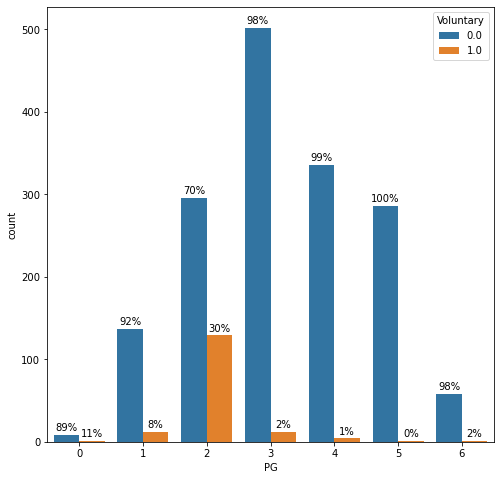

In [217]:
###PG Dist

plt.figure(figsize=(8,8))
ax = sns.countplot(x='PG',data=df_year,hue="Voluntary",order = plotorder)
bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r

    ax.text(left.get_x() + left.get_width()/2., height_l + 5, '{0:.0%}'.format(height_l/total), ha="center")
    ax.text(right.get_x() + right.get_width()/2., height_r + 5, '{0:.0%}'.format(height_r/total), ha="center")

<AxesSubplot:xlabel='PG', ylabel='count'>

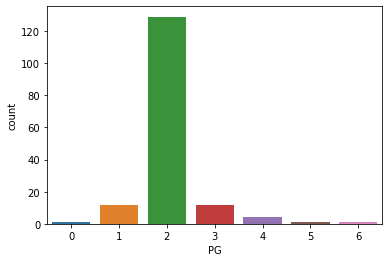

In [218]:
plotorder = leftdf['PG'].value_counts().sort_index().index
sns.countplot(x='PG',data=leftdf,order = plotorder)


<AxesSubplot:xlabel='PG', ylabel='count'>

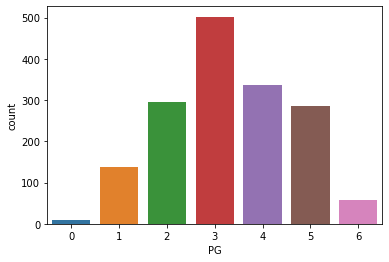

In [219]:
plotorder = notleftdf['PG'].value_counts().sort_index().index
sns.countplot(x='PG',data=notleftdf,order = plotorder)

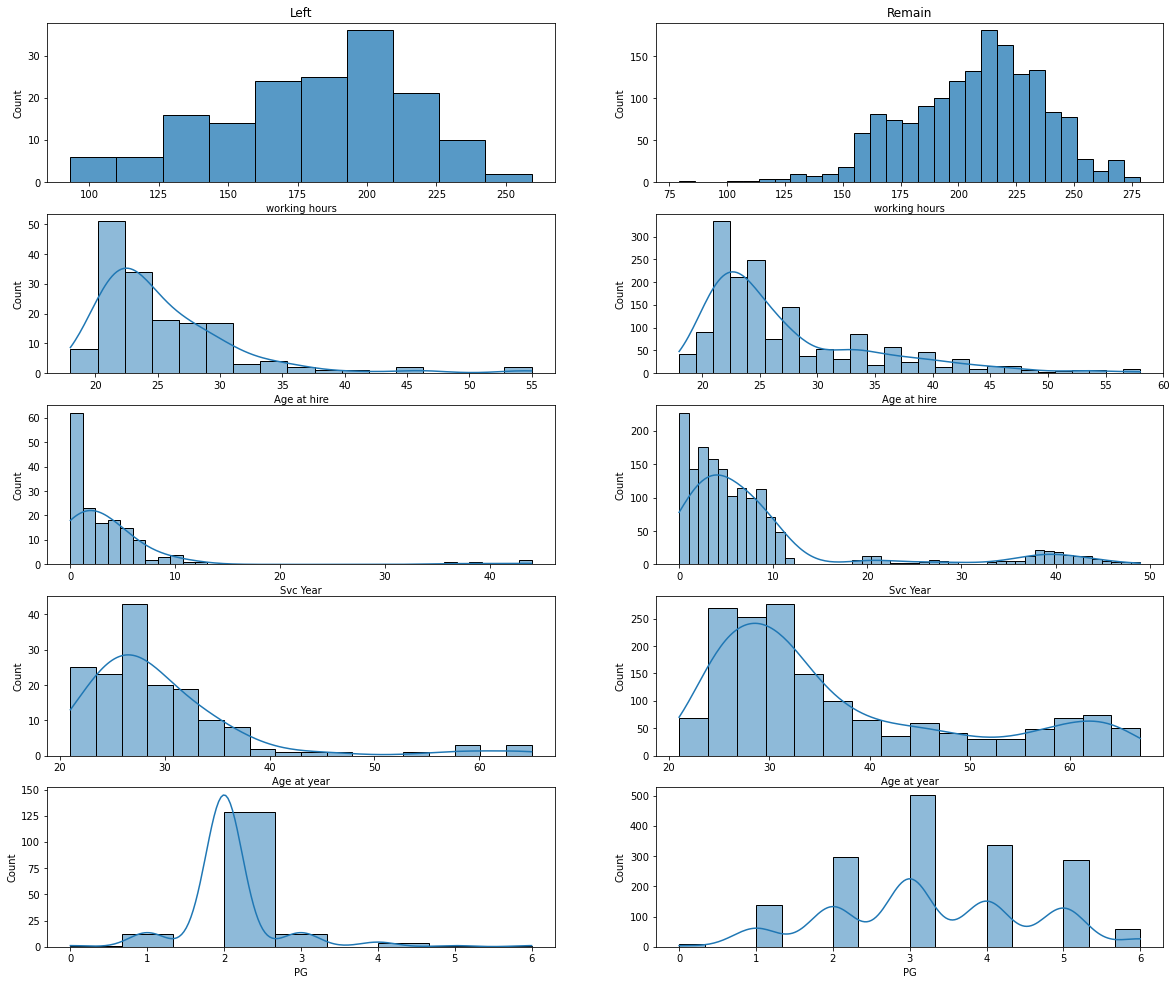

In [220]:
# Create a figure instance, and the two subplots
fig = plt.figure(figsize=(20,17))
ax1 = fig.add_subplot(521)
ax2 = fig.add_subplot(522)
ax3 = fig.add_subplot(523)
ax4 = fig.add_subplot(524)
ax5 = fig.add_subplot(525)
ax6 = fig.add_subplot(526)
ax7 = fig.add_subplot(527)
ax8 = fig.add_subplot(528)
ax9 = fig.add_subplot(529)
ax10 = fig.add_subplot(5,2,10)

# Tell pointplot to plot on ax1 with the ax argument (satisfaction level)
sns.histplot(leftdf['working hours'],ax = ax1).set_title('Left');
sns.histplot(notleftdf['working hours'],ax = ax2).set_title('Remain');
sns.histplot(leftdf['Age at hire'], kde=True,ax=ax3);
sns.histplot(notleftdf['Age at hire'], kde=True,ax=ax4);
sns.histplot(leftdf['Svc Year'], kde=True,ax=ax5);
sns.histplot(notleftdf['Svc Year'], kde=True,ax=ax6);
sns.histplot(leftdf['Age at year'], kde=True,ax=ax7);
sns.histplot(notleftdf['Age at year'], kde=True,ax=ax8);
sns.histplot(leftdf['PG'], kde=True,ax=ax9);
sns.histplot(notleftdf['PG'], kde=True,ax=ax10);


In [221]:
corr = leftdf.drop('Voluntary',axis=1).corr()

<AxesSubplot:>

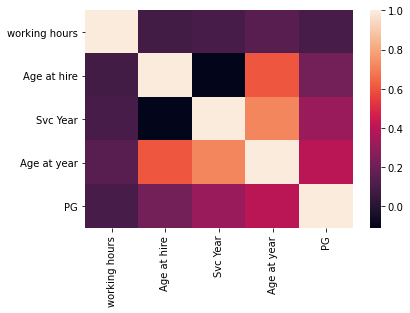

In [222]:
sns.heatmap(corr)

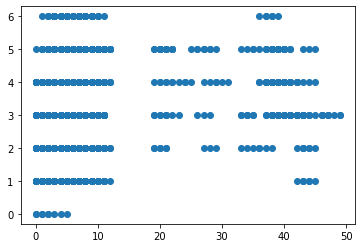

In [233]:
plt.scatter(df_year['Svc Year'],df_year['PG'])
plt.show()

In [234]:
df_year[['Svc Year','PG']].corr()

,Svc Year,PG
Svc Year,1.000000,0.198277
PG,0.198277,1.000000


# Model Generation

In [223]:
dummy1 = pd.get_dummies(df_year[['Job Code','Marital Status']],drop_first=True)
# Adding the results to the master dataframe
df_year = pd.concat([df_year, dummy1], axis=1)

In [224]:
df_year.drop(['Job Code','Marital Status'],axis=1,inplace=True)

In [225]:
#dropping Voluntary X for the df, y for the left
X = df_year.drop(['Voluntary'],axis=1)
y = df_year['Voluntary']

## Training the model

In [226]:
from sklearn import preprocessing,neighbors,svm
from sklearn.model_selection import train_test_split


In [227]:
#splitting the train and test sets
X_train, X_test, y_train,y_test= train_test_split(X,y,test_size=0.2)

### Train SVM Model 

In [228]:
# initiate svm object
clfsvm = svm.SVC()
# Fit the svm object with train data
clfsvm.fit(X_train,y_train)

SVC()

In [229]:
# Find the accuracy through the scoring process
accuracy = clfsvm.score(X_test,y_test)
accuracy

0.8935574229691877

In [230]:
pd.DataFrame(clfsvm.predict(X_test),y_test,columns=['ytest']).head()

,ytest
Voluntary,
0.0,0.0
0.0,0.0
0.0,0.0
0.0,0.0
0.0,0.0


### Train Decision Tree Model 

In [231]:
from sklearn import tree
clftree = tree.DecisionTreeClassifier(max_depth=3)
clftree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3)

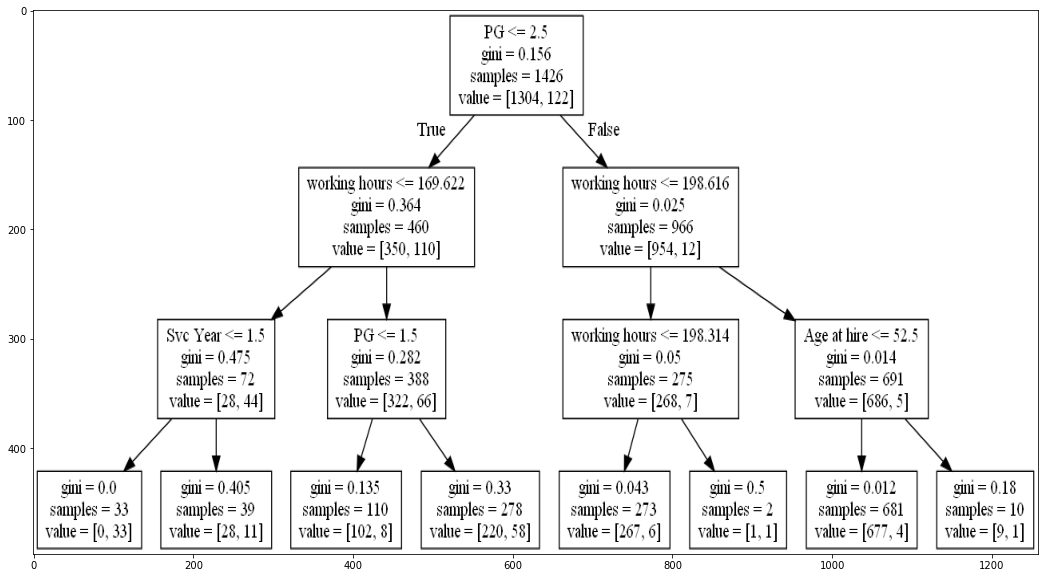

In [232]:
# Visualizing the decision tree
from sklearn import tree
from scipy import misc
import pydotplus
import graphviz
import imageio

def show_tree(decisionTree, file_path):
    tree.export_graphviz(decisionTree, out_file='tree.dot',feature_names=X_train.columns)
    graph = pydotplus.graphviz.graph_from_dot_file('tree.dot')
    graph.write_png(file_path)
    i = imageio.imread(file_path)
    
    fig, ax = plt.subplots(figsize=(18, 10))    
    ax.imshow(i, aspect='auto')

# To use it
show_tree(clftree, 'tree_CHS2019.png')

In [51]:
df_year

,working hours,Age at hire,Svc Year,Age at year,Voluntary,PG,Job Code_SR CONT HANDLING SPEC,Marital Status_Married,Marital Status_Single,Marital Status_Widowed
0,131.653846,21,45,66,0.0,1,0,1,0,0
1,165.550000,27,39,66,0.0,5,1,1,0,0
2,193.726852,22,11,33,0.0,5,1,1,0,0
3,214.495000,34,10,44,0.0,4,0,1,0,0
4,213.080000,22,10,32,0.0,4,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
479,221.177419,23,1,25,0.0,3,0,0,1,0
480,181.298387,37,1,38,0.0,2,0,1,0,0
481,186.900000,23,1,24,0.0,1,0,0,1,0
482,218.020270,30,1,31,0.0,3,0,1,0,0


In [52]:
df_2019 = df_year

<AxesSubplot:>

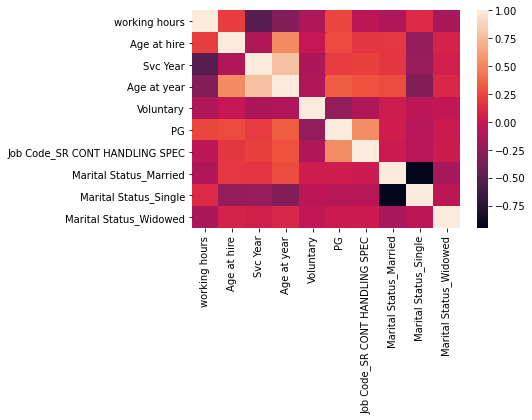

In [54]:
corr2019 = df_2019.corr()
sns.heatmap(corr2019)

In [235]:
df_CHS.shape

(274768, 31)

In [237]:
df_test=df_CHS.drop_duplicates(subset=['Emplid'],keep='last')
df_test=df_test.dropna(subset=['Citizenship Category'])
#df_raw=df_raw[df_raw['Citizenship Category'].str.contains('Singap')]
df_test.rename(columns={'As-of Month':'Last CHS Month'},inplace = True)

###Check duplicate employees 

no_dupe = len(df_test[df_test.duplicated(subset=['Name (Current)','Date of Birth'],keep=False)].sort_values('Name Known'))

print('{} dupe are found'.format(no_dupe))
###df_raw.to_csv('chs.csv')

0 dupe are found


,Last CHS Month,HC,Active/Left,Emplid,Previous Employee Id,Name Known,Name (Current),Date of Birth,Age,Citizenship Category,...,Job Code,Svc Grade,Date Left,Attrition Reason,Last Performance Grade,Perf Band,Perf Grade,Edu Class,Edu Type,Edu Institute
40818,2015-01-01,1,Left,F7636591K,-,MURUGAN A/L LETCHUMANAN,MURUGAN A/L LETCHUMANAN,09 Jun 1975,39.0,Malaysians (Non PR),...,CONTAINER HANDLING SPEC,-,24 Jan 2015,Vacation Of Office,-,-,-,Pre-Tertiary,FORM 3,"SMK TENANG STESEN, SEGAMAT, JOHOR"
37664,2015-01-01,1,Left,G2494702K,,TIN KO KO WIN,TIN KO KO WIN,13 Feb 1982,32.0,NTS,...,CONTAINER HANDLING SPEC,4AF,28 Jan 2015,Resignation,-,-,-,Prof,ITE SKILLS CERTIFICATE,ITE
37737,2015-01-01,1,Left,G5189719L,,GUIMBA DANILO RIVERA,GUIMBA DANILO RIVERA,23 Feb 1972,42.0,NTS,...,CONTAINER HANDLING SPEC,4AF,02 Jan 2015,Resignation (Discipline),-,B and above,-,Tertiary,BACHELOR,ARELLANO UNIVERSITY
37772,2015-01-01,1,Left,G6847126K,,LEW TSHUN SENG,LEW TSHUN SENG,07 Jul 1989,25.0,Malaysians (Non PR),...,CONTAINER HANDLING SPEC,4,02 Jan 2015,Resignation,-,NaN,-,Pre-Tertiary,SIJIL PELAJARAN MALAYSIA,"SMJK TIONG HUA, SANDAKAN, SABAH"
37813,2015-01-01,1,Left,G7882484R,,CHU DE H WEI,CHU DE H WEI,23 Apr 1987,27.0,Malaysians (Non PR),...,CONTAINER HANDLING SPEC,4,16 Jan 2015,Resignation,-,C+ and below,-,Prof,ITE SKILLS CERTIFICATE,ITE


In [240]:

df_test.drop(df_test.columns.difference(['Last CHS Month','Active/Left','Emplid','Attrition Reason', 'Citizenship Category', 'Date Left',
       'Date of Birth','Hire Date','Marital Status','Name Known' ,'Job Code']),axis=1,inplace=True)


df_test['Last CHS Month'] = df_test['Last CHS Month'].dt.date
df_test['Hire Date'] = pd.to_datetime(df_test['Hire Date']).dt.date

df_test['Date of Birth']=pd.to_datetime(df_test['Date of Birth']).dt.date
df_test['Date Left'] = pd.to_datetime(df_test['Date Left'],errors='coerce').dt.date

In [241]:
df_test.head()

,Last CHS Month,Active/Left,Emplid,Name Known,Date of Birth,Citizenship Category,Marital Status,Hire Date,Job Code,Date Left,Attrition Reason
40818,2015-01-01,Left,F7636591K,MURUGAN A/L LETCHUMANAN,1975-06-09,Malaysians (Non PR),-,2015-01-21,CONTAINER HANDLING SPEC,2015-01-24,Vacation Of Office
37664,2015-01-01,Left,G2494702K,TIN KO KO WIN,1982-02-13,NTS,Married,2014-07-17,CONTAINER HANDLING SPEC,2015-01-28,Resignation
37737,2015-01-01,Left,G5189719L,GUIMBA DANILO RIVERA,1972-02-23,NTS,Married,2012-11-01,CONTAINER HANDLING SPEC,2015-01-02,Resignation (Discipline)
37772,2015-01-01,Left,G6847126K,LEW TSHUN SENG,1989-07-07,Malaysians (Non PR),Single,2014-11-19,CONTAINER HANDLING SPEC,2015-01-02,Resignation
37813,2015-01-01,Left,G7882484R,CHU DE H WEI,1987-04-23,Malaysians (Non PR),Married,2014-06-18,CONTAINER HANDLING SPEC,2015-01-16,Resignation


In [244]:
hyearend = datetime.date(2018,12,31)
hyearstart=datetime.date(2018,1,1)

df_2018 = df_test[(df_test['Hire Date']>=hyearstart) & (df_test['Hire Date']<=hyearend)]

In [253]:
df_2018.to_csv('chs2018.csv')

In [248]:
hyearend = datetime.date(2019,12,31)
hyearstart=datetime.date(2019,1,1)

df_2019 = df_test[(df_test['Hire Date']>=hyearstart) & (df_test['Hire Date']<=hyearend)]

In [249]:
df_2019.to_excel(filename)



,Last CHS Month,Active/Left,Emplid,Name Known,Date of Birth,Citizenship Category,Marital Status,Hire Date,Job Code,Date Left,Attrition Reason


In [250]:
hyearend = datetime.date(2020,12,31)
hyearstart=datetime.date(2020,1,1)

df_2020 = df_test[(df_test['Hire Date']>=hyearstart) & (df_test['Hire Date']<=hyearend)]

In [255]:
df_2020.to_csv('chs2020.csv')

In [254]:
hyearend = datetime.date(2017,12,31)
hyearstart=datetime.date(2017,1,1)

df_2017 = df_test[(df_test['Hire Date']>=hyearstart) & (df_test['Hire Date']<=hyearend)]

df_2017.to_csv('chs2017.csv')